In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

from architectures.basic import BoundingBoxModel
from functions.datasets import get_loaders
from functions.loop_management import EarlyStopping
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [2]:
RUN_NUMBER = os.environ["RUN_NUMBER"]
dataset, train_loader, valid_loader = get_loaders(
    os.path.join("data", "train_images"),
    os.path.join("data", "train_coco_annotations.json")
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
cuda


In [3]:
model = BoundingBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")
    
    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()
            
            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    
    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss,
        model,
        path=os.path.join("checkpoints", f"checkpoint_1_bigger_basic_run_{RUN_NUMBER}.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

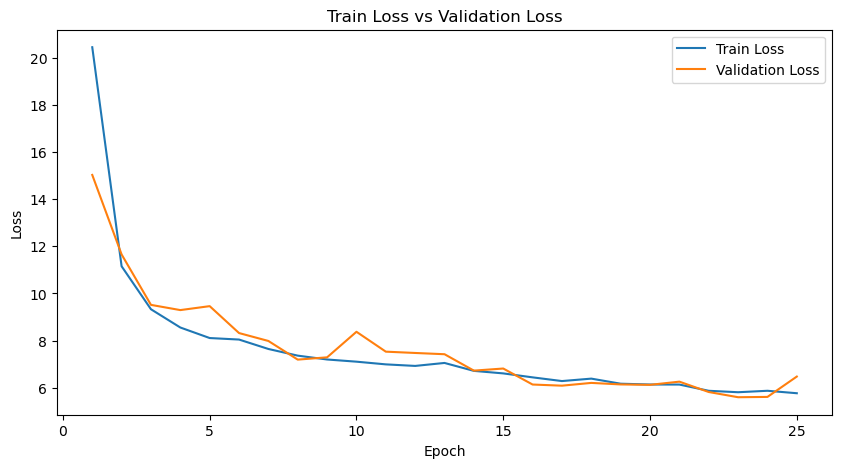

In [5]:
plot_losses(num_epochs, train_losses, val_losses)